# Run multiple transects

Calculate absorbed underice sunlight for multiple transects surveyed during the MOSAiC expedition.

Transect data contain snow depth, melt pond depth and ice thickness from the GEM2 and Magnaprobe dataset.

Itkin, Polona; Webster, Melinda; Hendricks, Stefan; Oggier, Marc; Jaggi, Matthias; Ricker, Robert; Arndt, Stefanie; Divine, Dmitry V; von Albedyll, Luisa; Raphael, Ian; Rohde, Jan; Liston, Glen E (2021): Magnaprobe snow and melt pond depth measurements from the 2019-2020 MOSAiC expedition. PANGAEA, https://doi.org/10.1594/PANGAEA.937781

In [10]:
# Append path for src modules
import sys
sys.path.append("../src")

import warnings  # to ignore future warnings
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from rtmodel import seaicert_mp
from plotting import plot_results, plot_thickness_profile
from mosaic_thickness import load_data, MAGNAPROBE_PATH

transect_filelist = Path('../data') / 'transect_filelist.txt'

The RT model is run on a series of transects that do not have file format or other issues.

_The transects files are being reformatted_

In [14]:
with open(transect_filelist) as f:
    savefiles = [p.strip() for p in f.readlines()]
print(f"There are {len(savefiles)} transects")

There are 51 transects


The Radiative Transfer model is run for each transect and the mean fluxes for each transect are calculated, along with other metrics.

In [11]:
agg_result = []
index = []
for fp in savefiles:
    #print(f"Running {fp}")
    df = load_data(fp)
    index.append(df.index[0])
    rt_df = seaicert_mp(df)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=FutureWarning)
        rt_df_mean = rt_df.mean()
        rt_df_mean["pond_fraction"] = (df.melt_pond_depth_m > 0.).sum() / len(df)
        agg_result.append(rt_df_mean)
        
time_series_df = pd.concat(agg_result, axis=1).T
time_series_df.index = index
time_series_df = time_series_df.where(time_series_df.surface_downwelling_radiative_flux > 0.).dropna(how='all')

In [12]:
time_series_df.head()

,latitude,snow_depth_m,melt_pond_depth_m,ice_thickness_mean_m,sw_absorbed_by_ocean,surface_albedo,surface_downwelling_radiative_flux,transect_distance_m,pond_fraction
2020-03-20 12:28:48,86.320012,0.276416,0.0,2.827835,0.048989,0.862939,28.402393,826.378365,0.0
2020-03-26 11:42:00,85.993010,0.285155,0.0,3.180240,0.064720,0.865854,52.608154,757.796953,0.0
2020-03-26 13:07:46,85.987113,0.099456,0.0,1.346686,0.857225,0.829570,50.354242,149.700230,0.0
2020-03-30 08:38:22,85.383635,0.251155,0.0,1.875517,0.106265,0.867358,74.268336,724.906012,0.0
2020-04-03 07:46:50,84.800291,0.284127,0.0,3.117478,0.077227,0.869034,97.230986,687.124740,0.0


Results are plotted.

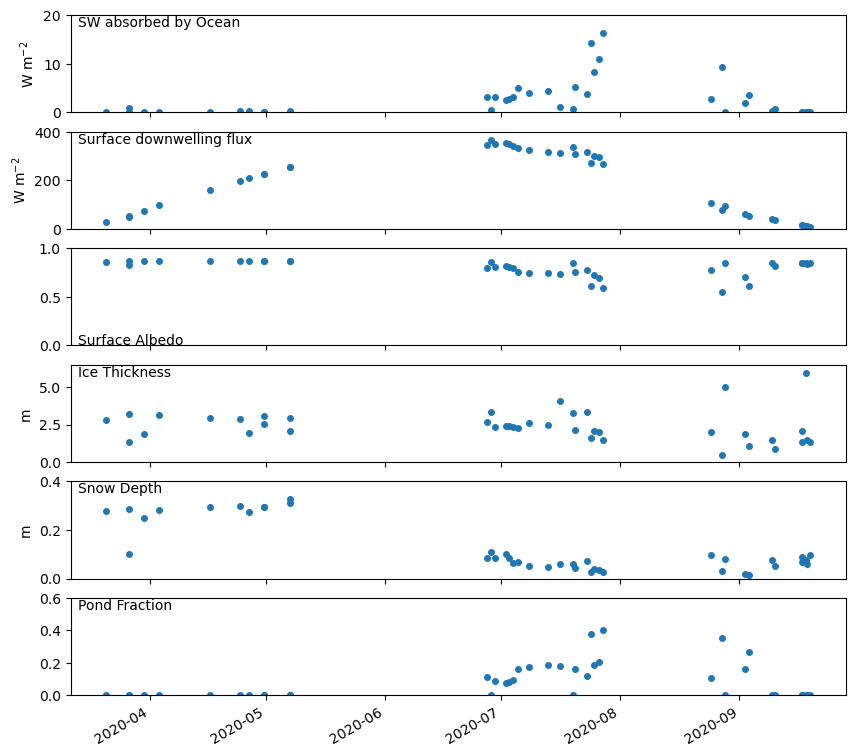

In [13]:
fig, ax = plt.subplots(6, 1, figsize=(10, 10))

time_series_df.sw_absorbed_by_ocean.plot(marker='o', ls='', markersize=4, ax=ax[0])
ax[0].set_ylim(0,20)
ax[0].set_ylabel("$\mathrm{W\ m^{-2}}$")
ax[0].text(0.01, 0.88, "SW absorbed by Ocean", transform=ax[0].transAxes)
ax[0].set_xticklabels([])

time_series_df.surface_downwelling_radiative_flux.plot(marker='o', ls='', markersize=4, ax=ax[1])
ax[1].set_ylim(0., 400.)
ax[1].set_ylabel("$\mathrm{W\ m^{-2}}$")
ax[1].text(0.01, 0.88, "Surface downwelling flux", transform=ax[1].transAxes)
ax[1].set_xticklabels([])

time_series_df.surface_albedo.plot(marker='o', ls='', markersize=4, ax=ax[2])
ax[2].set_ylim(0., 1.)
ax[2].text(0.01, 0.01, "Surface Albedo", transform=ax[2].transAxes)
ax[2].set_xticklabels([])

time_series_df.ice_thickness_mean_m.plot(marker='o', ls='', markersize=4, ax=ax[3])
ax[3].set_ylim(0., 6.5)
ax[3].set_ylabel('m')
ax[3].text(0.01, 0.88, "Ice Thickness", transform=ax[3].transAxes)
ax[3].set_xticklabels([])

time_series_df.snow_depth_m.plot(marker='o', ls='', markersize=4, ax=ax[4])
ax[4].set_ylim(0., .4)
ax[4].set_ylabel('m')
ax[4].text(0.01, 0.88, "Snow Depth", transform=ax[4].transAxes)
ax[4].set_xticklabels([])

time_series_df.pond_fraction.plot(marker='o', ls='', markersize=4, ax=ax[5])
ax[5].set_ylim(0., .6)
#ax[5].set_ylabel('m')
ax[5].text(0.01, 0.88, "Pond Fraction", transform=ax[5].transAxes)

fig.savefig('mosaic_time_series_from_transects.png')